<a href="https://colab.research.google.com/github/karenalmeida18/recognize-notes-api/blob/main/valida%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
from torchvision import datasets, models, transforms
from torch import optim, nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

IMAGES_TRAIN_DIR = '/content/drive/MyDrive/cedulas_dataset/train'
IMAGES_TEST_DIR = '/content/drive/MyDrive/cedulas_dataset/test'
IMAGES_VALIDATION_DIR = '/content/drive/MyDrive/validations/cedulas'
CEDULAS_DIR = '/content/drive/MyDrive/cedulas'

In [2]:
# Verifica ambiente de execução
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# exclui o diretorio de edição ipynb_checkpoints
class_list = list(filter(lambda f: not f.startswith(".ipynb_checkpoints"), os.listdir(IMAGES_TRAIN_DIR)))
# class_list = ['nota-100', 'nota-200', 'nota-2', 'nota-5', 'nota-50', 'nota-20', 'nota-10']
print(class_list)

['nota-10', 'nota-2', 'nota-20', 'nota-200', 'nota-5', 'nota-50', 'nota-100']


In [12]:
# Transformações a serem aplicadas de acordo com o modelo pretreinado do ImageNet
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [18]:
# Modelo pretreinado - VGG16
from torchvision import datasets, models, transforms
from torch import optim, nn

# Carrega o modelo pretreinado - sequeezenet
model = models.squeezenet1_1(pretrained=True).to(device)
# Fine tunning - Subtitui a camada de classificação (última)
model.classifier[1] = nn.Conv2d(512, len(class_list), kernel_size=(1, 1)).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/models/squeezeNet-32.pt', map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [15]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Acurácia: 95.58823529411765


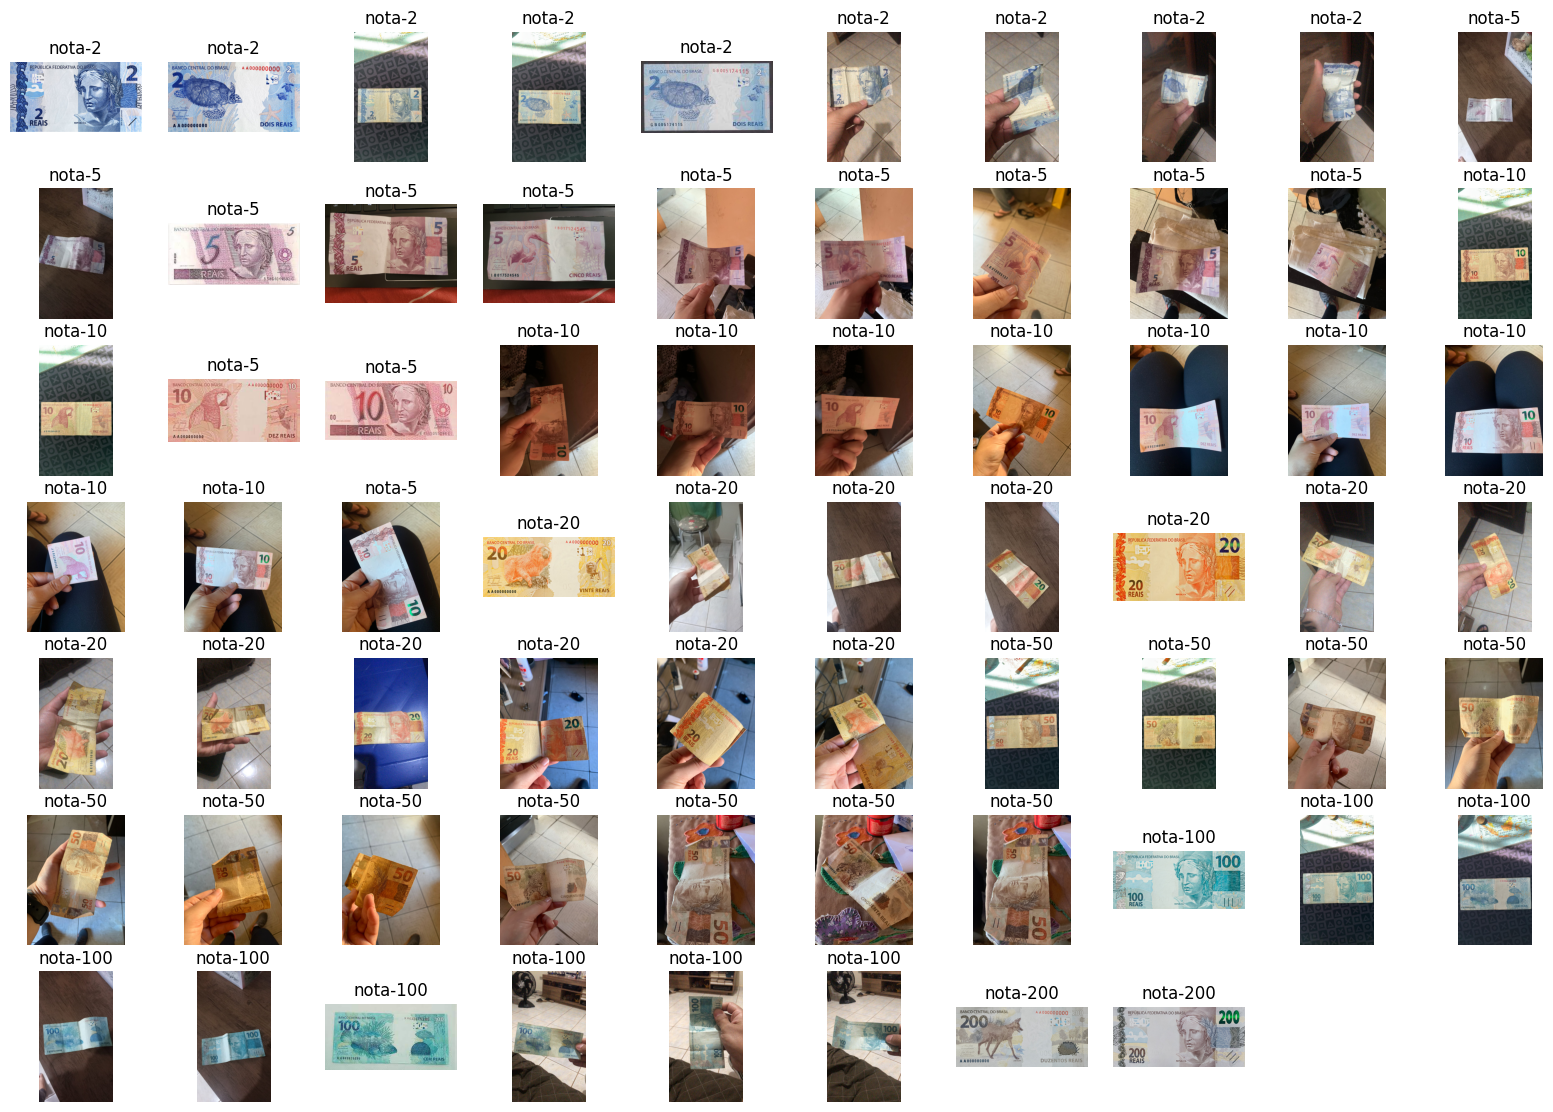

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score

model.eval()

true_labels = []
pred_labels = []
subplot_index = 1

with torch.no_grad():
  # Percorre cada imagem da pasta de validacao
  plt.figure(figsize=(20, 20))
  for j, folder in enumerate(os.listdir(IMAGES_VALIDATION_DIR)):
    for i, image_name in enumerate(os.listdir(os.path.join(IMAGES_VALIDATION_DIR, folder))):
        # Carrega a imagem atual
        img = Image.open(os.path.join(IMAGES_VALIDATION_DIR, folder, image_name))
        # Transforma a imagem pra trensor aplicando as transformaçoes de acordo com o modelo
        img_tensor = train_transform(img)
        # Simula o batch size 1
        batch = img_tensor.unsqueeze(0).to(device)

        # Passa o batch como entrada
        output = model(batch)
        # Usa a função softmax para obter probabilidades das classes
        probs = torch.nn.functional.softmax(output, dim=1)
        # Com o metodos argmax do tensor, pega o índice da classe que o modelo retornou
        pred_class = probs.argmax().item()
        pred_labels.append(pred_class)

        # Salva o label verdade da imagem no array
        true_class_name = 'nota-' + folder;
        true_labels.append(class_list.index(true_class_name))

        # Pega o nome da classe a partir do indice
        class_name = class_list[pred_class]

        # Plota o grafico com images e rotulos preditos
        plt.subplot(10, 10, subplot_index)
        subplot_index+=1
        plt.title(class_name)
        plt.axis("off")
        plt.imshow(img)

accuracy = accuracy_score(true_labels, pred_labels)
print(f'Acurácia: {accuracy*100}')
subplot_index=0
plt.show()

<Axes: >

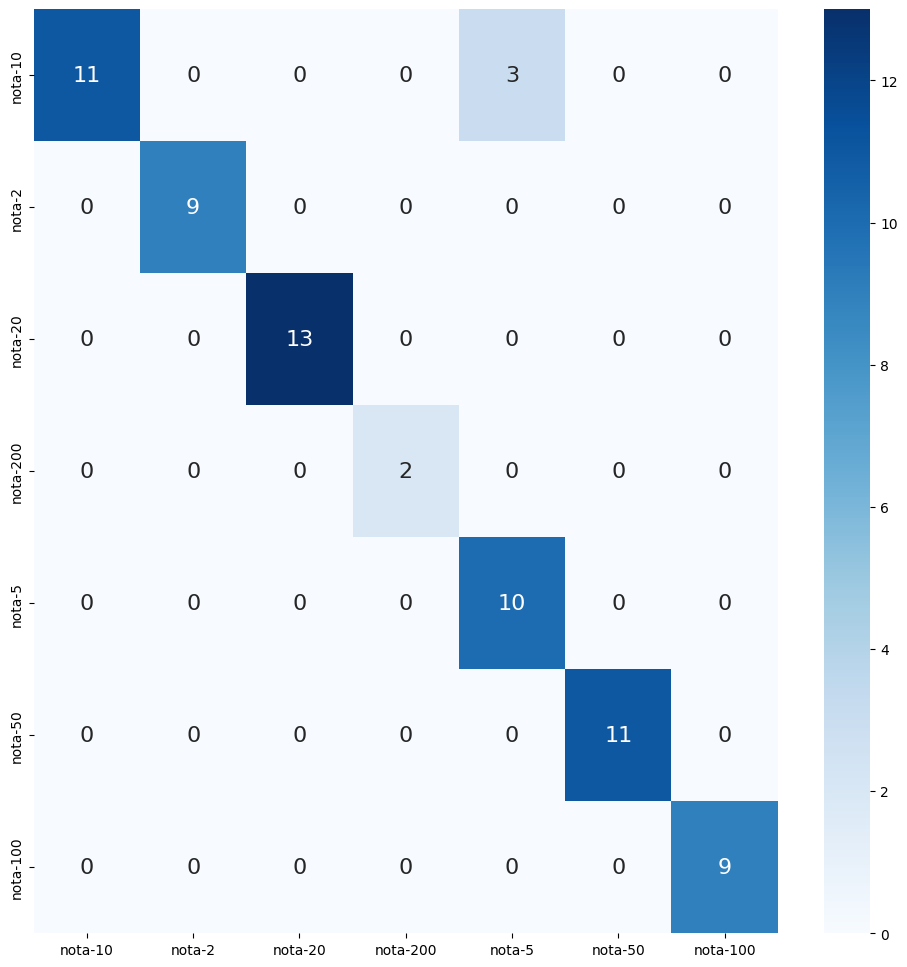

In [20]:
import sklearn.metrics as metrics
import seaborn as sn

conf_matrix = metrics.confusion_matrix(true_labels, pred_labels)


plt.figure(figsize=(12, 12))
sn.heatmap(conf_matrix.tolist(), annot=True, cmap='Blues', annot_kws={"size": 16}, fmt='d',xticklabels=class_list, yticklabels=class_list )